In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# There are four different probabilities p for positive outcomes (r = 1). The probability for negative outcomes (r = -1) is therefore 1-p.
# In the "low-reward" task, the best action has a probability for a positive outcome of 0.2, and the other action of 0.1. 
# In the "high-reward' task, these two probabilities are 0.9 and 0.8.
ProbabilityOfPositiveOutcome = np.matrix([[.2, .1], [.9, .8]])

# Each task lasts for 800 trials and there are 5,000 iterations.
NumberOfTrials = 800
NumberOfIterations = 5000 #5000

# The temperature parameter beta is set to 0.3 for all three learners (optimistic, rational and pessimistic).
beta = 0.3

In [2]:
# LearnerIdx refers to the identity of the learner: 0 for optimistic, 1 for rational and 2 for pessimistic
for learnerIdx in range(4):

    # There are three rational learners with different learning rates:
    if learnerIdx < 3:
        alpha = .01 * (learnerIdx == 0) + .1 * (learnerIdx == 1) + .4 * (learnerIdx == 2)
    # And a meta-learner with parameter w (instead of alpha):
    else:
        w = .1

    # We will compute the performance on each trial for all the iterations
    performance = np.nan * np.ones((NumberOfTrials, NumberOfIterations, len(ProbabilityOfPositiveOutcome)))

    # ConditionIdx refers to the task: 0 for the low-reward task, 1 for the high-reward task.
    for conditionIdx in range(len(ProbabilityOfPositiveOutcome)):

        NumberOfPositiveOutcomesBestAction = int(ProbabilityOfPositiveOutcome[conditionIdx, 0] * NumberOfTrials)
        NumberOfNegativeOutcomesBestAction = NumberOfTrials - NumberOfPositiveOutcomesBestAction
        
        NumberOfPositiveOutcomesWorstAction = int(ProbabilityOfPositiveOutcome[conditionIdx, 1] * NumberOfTrials)
        NumberOfNegativeOutcomesWorstAction = NumberOfTrials - NumberOfPositiveOutcomesWorstAction        

        for iterationIdx in range(NumberOfIterations):
            
            # The initial Q-values are set to 0. (The first element is the Q-value associated with the worst action, and the second with the best action.)
            Q = np.zeros(2)

            # We create a vector for the outcomes (r = 1 or r = -1) that will be observed on each trial
            OutcomesBestAction = np.concatenate((np.ones((NumberOfPositiveOutcomesBestAction,), dtype=np.int), - np.ones((NumberOfNegativeOutcomesBestAction,), dtype=np.int)))
            random.shuffle(OutcomesBestAction)

            OutcomesWorstAction = np.concatenate((np.ones((NumberOfPositiveOutcomesWorstAction,), dtype=np.int), - np.ones((NumberOfNegativeOutcomesWorstAction,), dtype=np.int)))
            random.shuffle(OutcomesWorstAction) 
            
            Outcomes = np.nan * np.ones(NumberOfTrials)
            
            for t in range(NumberOfTrials):
                
                ProbabilityToChooseBestAction = 1/(1+np.exp((Q[0]-Q[1])/beta))
                if random.random() < ProbabilityToChooseBestAction:
                    action = 1 # the chosen action is the best one.
                    Outcomes[t] = OutcomesBestAction[t]
                else:
                    action = 0 # the chosen action is the worst one.
                    Outcomes[t] = OutcomesWorstAction[t]
                performance[t, iterationIdx, conditionIdx] = action
                
                deltaQ = Outcomes[t] - Q[action]
                if learnerIdx < 3:
                    Q[action] += alpha * deltaQ
                else:
                    if t == 0:
                        ProbaReward = .5
                    else:
                        ProbaReward = (np.mean(Outcomes[:t]) + 1)/2
                    alphaPos = w * (1 - ProbaReward)
                    alphaNeg = w * ProbaReward
                    Q[action] += alphaPos * deltaQ * (deltaQ >= 0) + alphaNeg * deltaQ * (deltaQ < 0)

    if learnerIdx == 0:
        meanPerformanceRational1Low, meanPerformanceRational1High = np.mean(performance[:,:,0], axis=1), np.mean(performance[:,:,1], axis=1)
    elif learnerIdx == 1:
        meanPerformanceRational2Low, meanPerformanceRational2High = np.mean(performance[:,:,0], axis=1), np.mean(performance[:,:,1], axis=1)
    elif learnerIdx == 2:
        meanPerformanceRational3Low, meanPerformanceRational3High = np.mean(performance[:,:,0], axis=1), np.mean(performance[:,:,1], axis=1)
    else:
        meanPerformanceMetaLearnerLow, meanPerformanceMetaLearnerHigh = np.mean(performance[:,:,0], axis=1), np.mean(performance[:,:,1], axis=1)


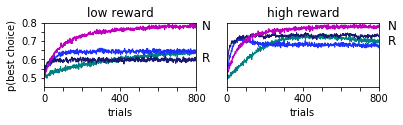

In [3]:
plt.figure(3)

# The left panel of figure 3:
plt.subplot(3,2,1)
plt.plot(meanPerformanceRational1Low, color = ((0/255,128/255,128/255,1)), linewidth=1)
plt.plot(meanPerformanceRational2Low, color = ((30/255,50/255,255/255,1)), linewidth=1)
plt.plot(meanPerformanceRational3Low, color = ((25/255,25/255,112/255,1)), linewidth=1) 
plt.plot(meanPerformanceMetaLearnerLow, 'm', linewidth=1)

plt.title('low reward')
plt.axis([0, 800, .45, .8])

plt.yticks([.5, .55, .6, .65, .7, .75, .8], ('0.5', '', '0.6', '', '0.7', '', '0.8'))
plt.ylabel('p(best choice)')

plt.xticks([0, 100, 200, 300, 400, 500, 600, 700, 800], ('0','','','','400','','','','800'))
plt.xlabel('trials')


# The right panel of figure 3:
plt.subplot(3,2,2)
plt.plot(meanPerformanceRational1High, color = ((0/255,128/255,128/255,1)), linewidth=1)
plt.plot(meanPerformanceRational2High, color = ((30/255,50/255,255/255,1)), linewidth=1)
plt.plot(meanPerformanceRational3High, color = ((25/255,25/255,112/255,1)), linewidth=1)
plt.plot(meanPerformanceMetaLearnerHigh, 'm', linewidth=1)

plt.title('high reward')
plt.axis([0, 800, .45, .8])

cur_axes = plt.gca()
cur_axes.axes.get_yaxis().set_visible(False)

plt.xticks([0, 100, 200, 300, 400, 500, 600, 700, 800], ('0','','','','400','','','','800'))
plt.xlabel('trials')

# The text around the figure:
legendToPlot = 'NR'
for indexLegend in range(2):
    plt.text(.5 , .855 - .11 * indexLegend, legendToPlot[indexLegend], fontsize=12, transform=plt.gcf().transFigure, horizontalalignment='center')
    plt.text(.93, .855 - .05 * indexLegend, legendToPlot[indexLegend], fontsize=12, transform=plt.gcf().transFigure, horizontalalignment='center')
    
plt.savefig('Figure3.png', dpi=150)
plt.show()